<a href="https://colab.research.google.com/github/pachterlab/CJP_2025/blob/main/supp_fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install ccpa
!pip3 install contrastive

  Preparing metadata (setup.py) ... done
  Created wheel for contrastive: filename=contrastive-1.2.0-py3-none-any.whl size=6899 sha256=a856cb34a1a8cd67afb72c19732be99647385b20054e1c7bbeec8936b1ec24f7
  Stored in directory: /root/.cache/pip/wheels/c0/b5/06/f9cee153dd8a0cd9f13a325b1f8cae67bf546c2d83ca98d736
Successfully built contrastive


In [4]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.stats import ortho_group

from contrastive import CPCA
import string

import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt

from functools import reduce
import warnings
warnings.filterwarnings('ignore')

In [52]:
def generate_simulation_data(
    dimension,
    n_principal_directions,
    n_overlap_directions,
    eigvals,
    n_samples = 1000,
    rem_variance_expl = 0.1,
    scale = 1,
    seed = 10
):

    """
    Generate simulated multivariate data with shared and unique principal directions.

    This function creates a foreground (`fg`) and background (`bg`),
    with specified covariance structures. Both datasets share a set of overlapping
    principal directions, while the foreground can have additional unique principal
    directions. Remaining directions are filled with small random noise.

    Parameters
    ----------
    dimension : int
        Total dimensionality of the simulated data.
    n_principal_directions : int
        Number of principal directions for the foreground dataset.
    n_overlap_directions : int
        Number of principal directions shared between foreground and background datasets.
    eigvals : array-like of shape (n_principal_directions,)
        Eigenvalues corresponding to the principal directions, defining the variance
        explained along each direction.
    n_samples : int, default=1000
        Number of samples to generate for each dataset. Will be at least as large as `dimension`.
    rem_variance_expl : float, default=0.1
        Fraction of variance assigned to remaining (non-principal) directions.
    scale : float, default=1
        Scaling factor for the background covariance matrix.
    seed : int, default=10
        Random seed for reproducibility.
    """

    np.random.seed(seed)

    n_noise_dir_fg = dimension - n_principal_directions
    n_uniq_dir_fg = n_principal_directions - n_overlap_directions
    n_noise_dir_bg = n_noise_dir_fg + n_uniq_dir_fg

    # Construct an orthonormal basis U for the `n_principal_dir`
    R = np.random.randn(dimension, n_principal_directions)
    U, _ = np.linalg.qr(R)
    U_bg = U[:,:n_overlap_directions]

    eigvals = eigvals[:n_principal_directions]

    Lambda = np.diag(eigvals[:n_principal_directions])
    Lambda_bg = np.diag(eigvals[:n_overlap_directions])

    # The remaining directions explain a small fraction of the
    # total variance
    D = rem_variance_expl * np.eye(n_noise_dir_fg)
    D_bg = rem_variance_expl * np.eye(n_noise_dir_bg)

    D = np.eye(dimension) - (U @ U.T)
    D_bg = np.eye(dimension) - (U_bg @ U_bg.T)
    # D = np.pad(D, ((n_principal_directions, 0), (n_principal_directions, 0)), 'constant')
    # D_bg = np.pad(D_bg, ((n_overlap_directions, 0), (n_overlap_directions, 0)), 'constant')

    sigma_fg = U @ Lambda @ U.T + D

    # for the background, principal directions are the same, but
    # variance may be scaled in those directions
    sigma_bg = U_bg @ (scale * Lambda_bg) @ U_bg.T + (scale * D_bg)
    n_samples = max(n_samples, dimension)

    fg = np.random.multivariate_normal(mean=np.zeros(dimension), cov=sigma_fg, size=n_samples)
    bg = np.random.multivariate_normal(mean=np.zeros(dimension), cov=sigma_bg, size=n_samples)

    # Porject, and make a dataframe for plotitng
    fg_proj = pd.DataFrame(
        data=fg @ U,
        columns = [f'X{i}' for i in range(n_principal_directions)]
    ).assign(is_target = True, data_id="target")

    bg_proj = pd.DataFrame(
        data=bg @ U,
        columns=[f'X{i}' for i in range(n_principal_directions)]
    ).assign(is_target = False, data_id="background")


    output = pd.concat([fg_proj, bg_proj])
    return fg, bg, output

In [55]:
dimension = 1200
n_principal_directions = 3
n_overlap_directions = 2 # Only 1 direction is unique to target
eigvals = np.array([50, 22 ,20, 7, 1])

target, background, df = generate_simulation_data(
    dimension, n_principal_directions, n_overlap_directions, eigvals = eigvals, n_samples = 2000, seed=4234)

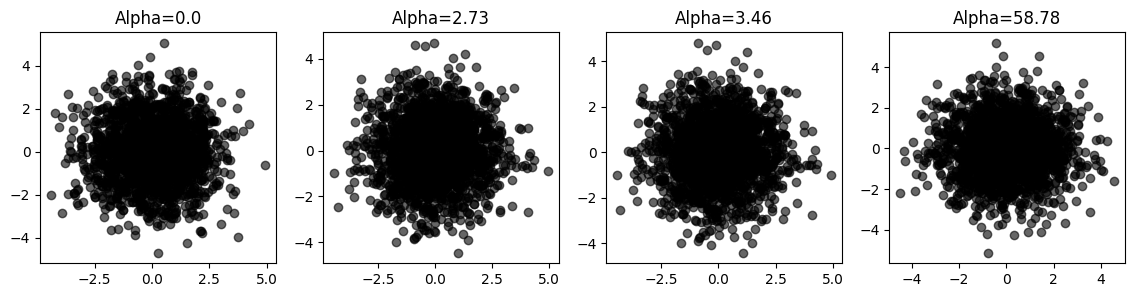

In [77]:

pca = PCA(n_components=1000)
both = np.concatenate([target,background])
both_ = pca.fit_transform(both)
target_ = both_[:2000]
background_ = both_[2000:]



# run standard cPCA to get alphas,
mdl = CPCA()
mdl.fit_transform(target_, background_, plot=True)

In [78]:
pdt = []
pdb = []

alphas = [0.1,2.73,3.46,58.78]

for alpha in alphas:
  print('starting',alpha)
  mdl = CPCA()
  mdl.fit(target_, background_)
  # first reduce to  1,000 dimensions
  pdt_ = mdl.transform(target_, alpha_value=alpha, alpha_selection='manual')
  pdb_ = mdl.transform(background_, alpha_value=alpha, alpha_selection='manual')

  pdt.append(pdt_)
  pdb.append(pdb_)
  print('done with ',alpha)

starting 0.1
done with  0.1
starting 2.73
done with  2.73
starting 3.46
done with  3.46
starting 58.78
done with  58.78


In [58]:
# rayleigh quotient
# standardize
def standardize_array(array):
        standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)
        return np.nan_to_num(standardized_array)

target_std = standardize_array(target)
background_std = standardize_array(background)
Sigma_t = np.cov(target_std, rowvar=False)
Sigma_b = np.cov(background_std, rowvar=False)

# add very small trace to sigma_b


try:
  eigvals_rq, eigvecs_rq = eigh(Sigma_t, Sigma_b)
except:
  print('bad')
  Sigma_b += np.eye(Sigma_b.shape[0]) * 1e-10 * np.trace(Sigma_b)
  eigvals_rq, eigvecs_rq = eigh(Sigma_t, Sigma_b)

# Take top 2 generalized eigenvectors
V_rq = eigvecs_rq[:, -2:]
target_proj_rq = target_std @ V_rq
background_proj_rq = background_std @ V_rq


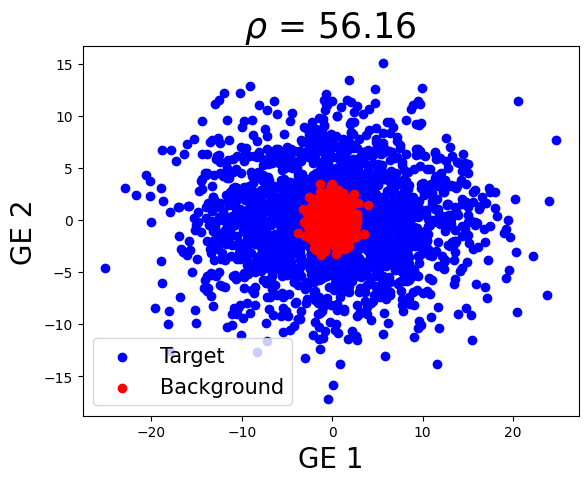

In [84]:
# plot each one
rat = np.var(target_proj_rq[:,1])/np.var(background_proj_rq[:,1])
plt.scatter(target_proj_rq[:,1],target_proj_rq[:,0],color='blue',label='Target')
plt.scatter(background_proj_rq[:,1],background_proj_rq[:,0],color='red',label='Background')
plt.title( r'$\rho$ = '+ f'{rat:.2f}',fontsize=25)
plt.xlabel('GE 1',fontsize=20)
plt.ylabel('GE 2',fontsize=20)
plt.legend(fontsize=15)


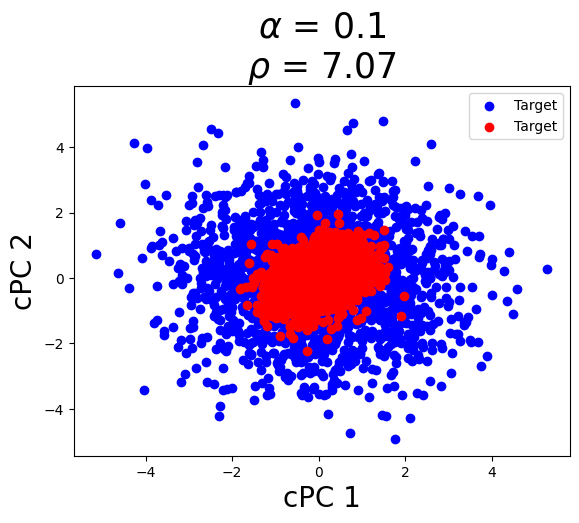

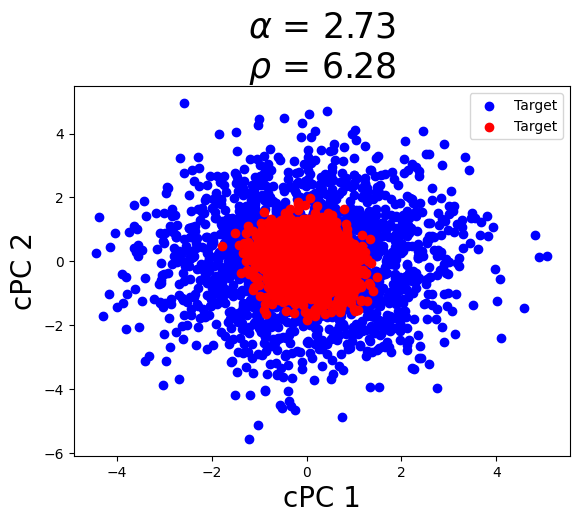

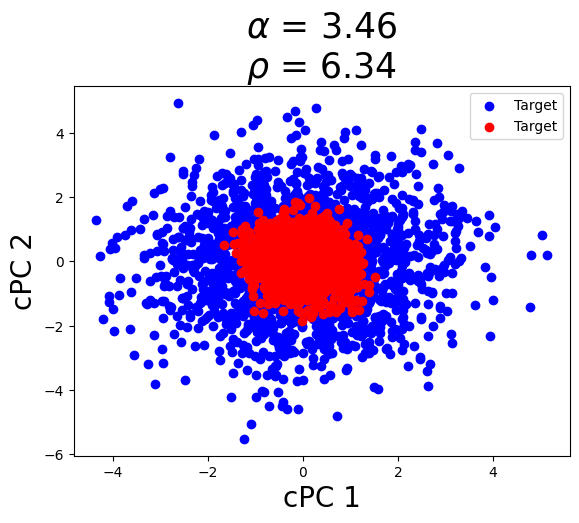

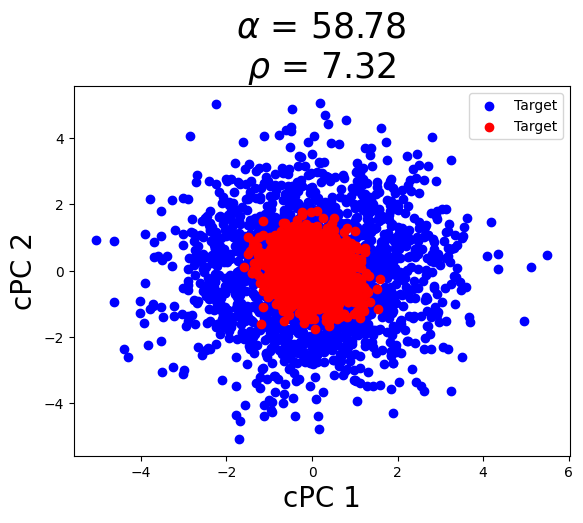

In [82]:
for i in range(4):
  t = pdt[i][:,0]
  b = pdb[i][:,0]
  rat = np.var(t)/np.var(b)
  plt.scatter(pdt[i][:,1],pdt[i][:,0],color='blue',label='Target')
  plt.scatter(pdb[i][:,1],pdb[i][:,0],color='red',label='Target')
  plt.xlabel('cPC 1',fontsize=20)
  plt.ylabel('cPC 2',fontsize=20)
  plt.title(r'$\alpha$ = ' +f'{alphas[i]}\n' + r'$\rho$ = '+ f'{rat:.2f}',fontsize=25)
  plt.legend()
  plt.show()